# Deep Reinforcement Learning for Portfolio Optimization


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

By leveraging state-of-the-art DRL algorithms, we aim to create a robust trading strategy that dynamically adjusts portfolio allocations to maximize returns while minimizing risks.

Policy network architecture: **MLP backbone**

- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

The workflow includes:

- Data preprocessing
- Feature engineering
- Environment setup
- Training of DRL agents
- Backtesting
- Benchmarking against traditional strategies


## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [88]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

import torch

from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import (
    backtest_stats,
    get_daily_return,
    get_baseline, backtest_plot
)
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as PGAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
experiment_name = "portfolio_optimization_mlp_multi_agent"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [5]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-01', '2023-04-29')
Testing period: ('2023-04-30', '2025-04-28')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [6]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


df = download_data(config_tickers.DOW_30_TICKER, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76761, 8)


==========

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [7]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(df)

# TODO: Normalise the data??

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [50]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [69]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [ ]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)
test_env = initialize_portfolio_env(test_df)

In [ ]:
train_agent = DRLAgent(train_env)

## Training


Configure model algorithms


In [ ]:
def prepare_model_configs():
    model_configs = [
        (A2C, "A2C", {}),
        (PPO, "PPO", {}),
        (SAC, "SAC", {}),
        (DDPG, "DDPG", {}),
        (TD3, "TD3", {}),
    ]

    return model_configs


model_configs = prepare_model_configs()

Train multiple reinforcement learning (RL) models using the specified training environment and configuration.


In [ ]:
def train_models(agent, model_configs, results_dir, total_timesteps=200_000):
    training_times = {}
    trained_models = {}
    for model_class, model_name, model_kwargs in model_configs:
        print(f"Training {model_name}...")
        start_time = time.time()

        model = agent.get_model(
            model_name=model_name.lower(),
            model_kwargs=model_kwargs,
            policy_kwargs=model_kwargs.get("policy_kwargs", {}),
        )

        trained_model = agent.train_model(
            model,
            tb_log_name=f"{experiment_name}_{model_name.lower()}",
            total_timesteps=total_timesteps,
        )

        model_path = f"{results_dir}/{model_name.lower()}_model"
        trained_model.save(model_path)

        trained_models[model_name] = trained_model

        end_time = time.time()
        training_times[model_name] = (
            end_time - start_time
        ) / 60  # Training time in minutes
        print(
            f"{model_name} training completed in {training_times[model_name]:.2f} minutes."
        )

    return trained_models, training_times

In [83]:
trained_models, training_times = train_models(train_agent, model_configs, results_dir)

Training A2C...
{}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
A2C training completed in 0.02 minutes.
Training PPO...
{}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial portfolio value:100000
Final portfolio value: 35011.58984375
Final accumulative portfolio value: 0.35011589527130127
Maximum DrawDown: -0.6746209256155983
Sharpe ratio: -0.7356261926748716
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 1.79e+03      |
|    ep_rew_mean     | -1.04         |
| time/              |               |
|    fps             | 103           |
|    iterations      | 1             |
|    time_elapsed    | 19            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0043678763 |
--------------------------------------
PPO training completed in 0.35 minutes.
Training SAC...
{}
Using cpu 

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.85GB
  warnings.warn(


SAC training completed in 0.02 minutes.
Training DDPG...
{}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.85GB
  warnings.warn(


DDPG training completed in 0.02 minutes.
Training TD3...
{}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 34.93GB > 3.77GB
  warnings.warn(


TD3 training completed in 0.02 minutes.


In [84]:
training_times_df = pd.DataFrame(
    list(training_times.items()), columns=["model", "training_duration (min)"]
)
training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

print("Training summary:")
display(training_times_df)

Training summary:


,model,training_duration (min)
0,A2C,0.019687
1,PPO,0.345338
2,SAC,0.016080
3,DDPG,0.018496
4,TD3,0.019093


## Model loading


Load the trained models from memory for analysis without the need for time consuming retraining


In [ ]:
def load_models(model_configs, results_dir):
    models = {}
    for model_class, name, _ in model_configs:
        model_path = f"{results_dir}/{name.lower()}_model.zip"
        if os.path.exists(model_path):
            print(f"Loading saved model for {name}...")
            models[name] = model_class.load(model_path)
        else:
            print(f"No saved model found for {name}.")
    return models


# If you already trained above you can skip this; otherwise:
# trained_models = load_models(model_configs, results_dir)

## Backtesting


- Evaluates the performance of the RL models/algorithms in a trading environment.
- We do this by calculating the **cumulative portfolio value** and **performance metrics** for each RL model.


In [103]:
env_kwargs = {"initial_amount": 100_000}

In [ ]:
def manual_backtest(model, env, initial_amount):
    """
    Runs the env step by step, predicting actions with `model`, and
    builds a DataFrame of dates, daily returns, and account values.
    """
    # reset and get initial obs
    obs, _ = env.reset()
    done = False

    # start from initial capital
    portfolio_value = initial_amount

    dates, daily_rets, account_vals = [], [], []

    while not done:
        # predict an action
        action, _ = model.predict(obs, deterministic=True)
        # step the environment
        result = env.step(action)

        # handle gymnasium vs. gym return signature
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            obs, reward, done, info = result

        # update portfolio value from the reward
        portfolio_value *= 1 + reward

        # record
        daily_rets.append(reward)
        account_vals.append(portfolio_value)

        # grab the current date from info
        dates.append(info["end_time"])

    return pd.DataFrame(
        {
            "date": dates,
            "daily_return": daily_rets,
            "account_value": account_vals,
        }
    )


def backtest_rl_strategies_manual(models, test_env, env_kwargs):
    out = {}
    for name, model in models.items():
        print(f"\nManual backtest: {name}")
        df_ret = manual_backtest(model, test_env, env_kwargs["initial_amount"])
        # ensure it's sorted by date
        df_ret = df_ret.sort_values("date").reset_index(drop=True)

        # compute performance stats
        stats = backtest_stats(df_ret, value_col_name="account_value")
        out[name] = {"df": df_ret, "stats": stats}
    return out


results = backtest_rl_strategies_manual(trained_models, test_env, env_kwargs)


Manual backtest: A2C
Initial portfolio value:100000
Final portfolio value: 119654.7578125
Final accumulative portfolio value: 1.1965476274490356
Maximum DrawDown: -0.1476527422585362
Sharpe ratio: 0.8099183925925048
Annual return          0.093592
Cumulative returns     0.173234
Annual volatility      0.135197
Sharpe ratio           0.730684
Calmar ratio           0.620648
Stability              0.813922
Max drawdown          -0.150798
Omega ratio            1.145984
Sortino ratio          1.052764
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.945923
Daily value at risk   -0.016641
dtype: float32

Manual backtest: PPO
Initial portfolio value:100000
Final portfolio value: 118087.28125
Final accumulative portfolio value: 1.1808727979660034
Maximum DrawDown: -0.1432166100811203
Sharpe ratio: 0.7657829085693567
Annual return          0.085899
Cumulative returns     0.158536
Annual volatility      0.132968
Sharpe ratio           0.687466
Calmar ra

In [ ]:
def plot_backtest_results():
    os.makedirs(f"{results_dir}/backtest_plots", exist_ok=True)
    for name, res in results.items():
        print(f"Plotting {name}…")
        backtest_plot(
            account_value=res["df"],
            baseline_start=test_start_date,
            baseline_end=end_date,
            baseline_ticker="SPY",
            value_col_name="account_value",
        )


plot_backtest_results()

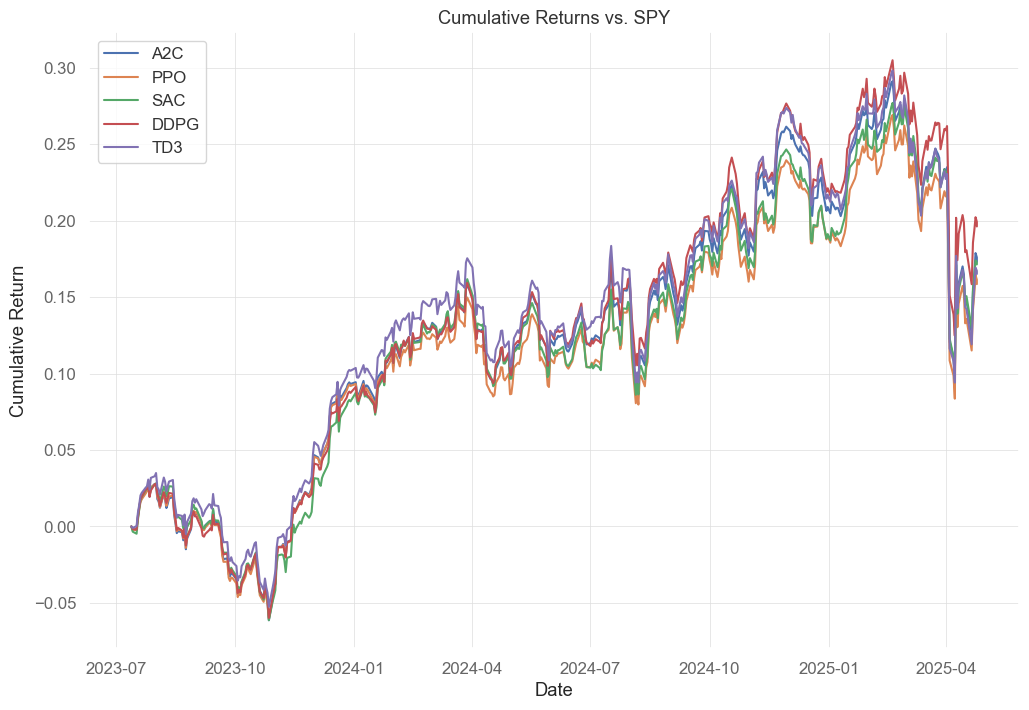

In [ ]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        df = res["df"]
        # compute cumulative returns from account_value
        cum = df["account_value"] / df["account_value"].iloc[0] - 1
        plt.plot(df["date"], cum, label=name)
    plt.title("Cumulative Returns vs. SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)

## Benchmarks


In [310]:
def compute_mpt_benchmark(test, env_kwargs):
    dates_test = test.date.unique()
    min_vals = [env_kwargs["initial_amount"]]
    for i in range(len(dates_test) - 1):
        curr = test[test.date == dates_test[i]]
        nxt = test[test.date == dates_test[i + 1]]
        covm = np.array(curr.cov_list.values[0])
        ef = EfficientFrontier(None, covm, weight_bounds=(0, 1))
        ef.min_volatility()
        w = ef.clean_weights()
        prices = curr.close.values
        nextp = nxt.close.values
        shares = np.array(list(w.values())) * min_vals[-1] / prices
        min_vals.append(np.dot(shares, nextp))
    min_df = pd.DataFrame({"date": dates_test, "account_value": min_vals})
    stats_mpt = backtest_stats(min_df, value_col_name="account_value")
    return {"df": min_df, "stats": stats_mpt}


mpt_benchmark = compute_mpt_benchmark(test_df, env_kwargs)

Annual return          0.056181
Cumulative returns     0.114308
Annual volatility      0.110983
Sharpe ratio           0.548918
Calmar ratio           0.536697
Stability              0.849925
Max drawdown          -0.104678
Omega ratio            1.104592
Sortino ratio          0.790013
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018173
Daily value at risk   -0.013741
dtype: float64


In [311]:
def compute_equal_weighted_benchmark(test, env_kwargs):
    ew_daily = test.groupby("date")["close"].apply(
        lambda d: d.pct_change().fillna(0).mean()
    )

    ew_df = ew_daily.reset_index(name="daily_return")
    ew_df["account_value"] = (ew_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")
    return {"df": ew_df, "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs)

Annual return          1.127944e+50
Cumulative returns     1.292631e+99
Annual volatility      2.998175e+00
Sharpe ratio           4.977197e+01
Calmar ratio                    NaN
Stability              9.838623e-01
Max drawdown           0.000000e+00
Omega ratio                     NaN
Sortino ratio                   inf
Skew                            NaN
Kurtosis                        NaN
Tail ratio             2.153517e+00
Daily value at risk    2.144285e-01
dtype: float64


In [312]:
def compute_equal_weighted_benchmark(df, initial_amount=100_000):
    # Pivot to have one column per ticker
    price_wide = df.pivot_table(
        index="date", columns="tic", values="close"
    ).sort_index()

    # Compute each ticker's daily return, then average equally
    daily_rets = price_wide.pct_change().fillna(0).mean(axis=1)

    # Build the equity curve
    ew_df = pd.DataFrame({"date": daily_rets.index, "daily_return": daily_rets.values})
    ew_df["account_value"] = (ew_df["daily_return"] + 1).cumprod() * initial_amount

    # Compute performance statistics
    stats_ew = backtest_stats(ew_df, value_col_name="account_value")

    return {"df": ew_df.reset_index(drop=True), "stats": stats_ew}


ew_benchmark = compute_equal_weighted_benchmark(test_df, env_kwargs["initial_amount"])

Annual return          0.101592
Cumulative returns     0.211178
Annual volatility      0.135844
Sharpe ratio           0.781401
Calmar ratio           0.691055
Stability              0.869843
Max drawdown          -0.147010
Omega ratio            1.154416
Sortino ratio          1.150707
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.975127
Daily value at risk   -0.016694
dtype: float64


In [313]:
def compute_spy_benchmark(test, env_kwargs):
    spy_close = get_baseline("SPY", test.date.min(), test.date.max())["close"]
    spy_ret = spy_close.pct_change().dropna()
    spy_df = pd.DataFrame({"date": spy_ret.index, "daily_return": spy_ret.values})
    spy_df["account_value"] = (spy_df.daily_return + 1).cumprod() * env_kwargs[
        "initial_amount"
    ]
    stats_spy = backtest_stats(spy_df, value_col_name="account_value")
    return {"df": spy_df, "stats": stats_spy}


spy_benchmark = compute_spy_benchmark(test_df, env_kwargs)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (498, 8)
Annual return          0.171815
Cumulative returns     0.367115
Annual volatility      0.164153
Sharpe ratio           1.049459
Calmar ratio           0.916089
Stability              0.877004
Max drawdown          -0.187552
Omega ratio            1.223921
Sortino ratio          1.560228
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.913881
Daily value at risk   -0.019998
dtype: float64


In [314]:
benchmarks = {
    "MPT": mpt_benchmark,
    "EW": ew_benchmark,
    "SPY": spy_benchmark,
}

results.update(benchmarks)

## Performance Summary


In [315]:
perf_stats = pd.DataFrame({key.upper(): res["stats"] for key, res in results.items()})
display(perf_stats)

,A2C,PPO,SAC,DDPG,TD3,MPT,EW,SPY
Annual return,0.093592,0.085899,0.092652,0.105567,0.089396,0.056181,0.101592,0.171815
Cumulative returns,0.173234,0.158536,0.171434,0.196273,0.165208,0.114308,0.211178,0.367115
Annual volatility,0.135197,0.132968,0.132488,0.130920,0.137618,0.110983,0.135844,0.164153
Sharpe ratio,0.730684,0.687466,0.736444,0.833668,0.692186,0.548918,0.781401,1.049459
Calmar ratio,0.620648,0.587311,0.654851,0.764414,0.568378,0.536697,0.691055,0.916089
Stability,0.813922,0.798477,0.805837,0.853621,0.782319,0.849925,0.869843,0.877004
Max drawdown,-0.150798,-0.146258,-0.141486,-0.138102,-0.157283,-0.104678,-0.147010,-0.187552
Omega ratio,1.145984,1.135993,1.143184,1.165040,1.138507,1.104592,1.154416,1.223921
Sortino ratio,1.052764,0.991311,1.057881,1.207043,0.997298,0.790013,1.150707,1.560228
Skew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


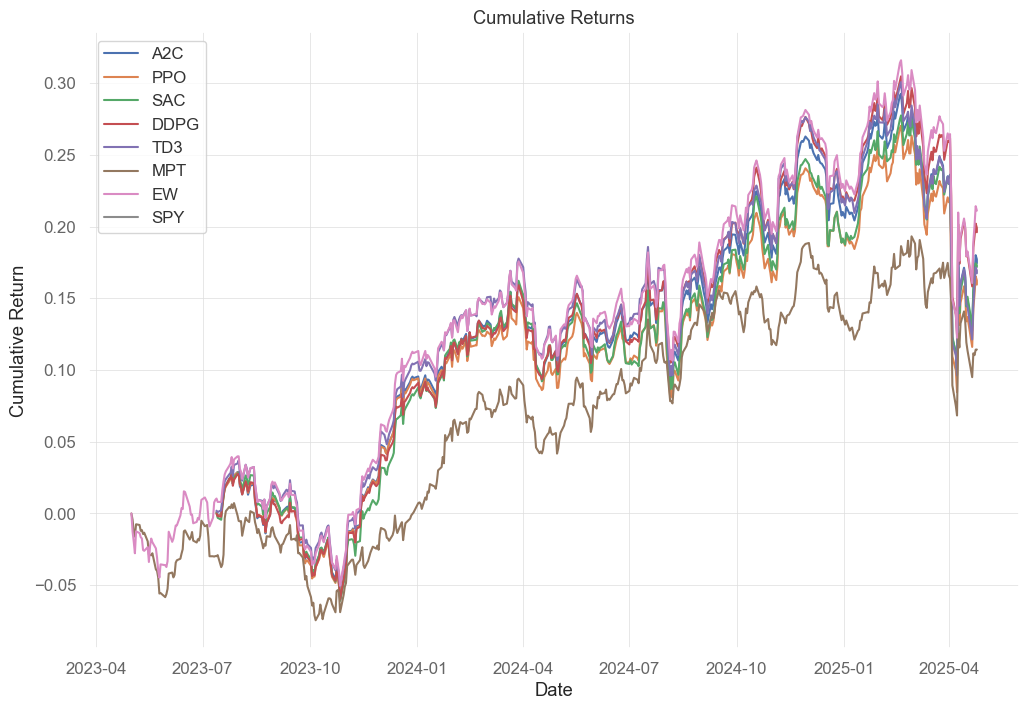

In [316]:
def plot_cumulative_returns(results):
    plt.figure(figsize=(12, 8))
    for name, res in results.items():
        # Ensure the date column is converted to datetime
        res["df"]["date"] = pd.to_datetime(res["df"]["date"])
        # Filter data to start from the trade start date
        filtered_df = res["df"][res["df"]["date"] >= test_start_date]
        cum = (
            (filtered_df["daily_return"] + 1).cumprod() - 1
            if "daily_return" in filtered_df
            else filtered_df["account_value"] / filtered_df["account_value"].iloc[0] - 1
        )
        plt.plot(filtered_df["date"], cum, label=name)
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


plot_cumulative_returns(results)